---------- point1 ----------
最尤推定 ξ: -0.03496503496503539 σ: 4.534878508128582 RV: 29.54047213143604
最尤推定 ξ: 0.10489510489510434 σ: 2.9623711642790713 RV: 27.087760243023872
42.5 %の確率で極値増加
最尤推定 ξ: 0.2939652939652935 σ: 2.3985754262239167 RV: 36.576108937732165
最尤推定 ξ: 0.019425019425018952 σ: 2.009233002565048 RV: 17.23120773410899
8.1 %の確率で極値増加
---------- point2 ----------
最尤推定 ξ: -0.19813519813519856 σ: 6.746209580926486 RV: 30.219530022821868
最尤推定 ξ: 0.19554519554519512 σ: 4.267245510433559 RV: 47.657123419981495
80.2 %の確率で極値増加
最尤推定 ξ: 0.12043512043512006 σ: 2.8480358684358014 RV: 27.291384176198083
最尤推定 ξ: 0.12820512820512775 σ: 2.95179008812717 RV: 28.525626588092308
50.9 %の確率で極値増加
---------- point3 ----------
最尤推定 ξ: 0.08417508417508379 σ: 2.558146475749129 RV: 24.967924397522015
最尤推定 ξ: 0.08158508158508115 σ: 4.229242874389499 RV: 34.99692812171647
66.9 %の確率で極値増加
最尤推定 ξ: 0.2913752913752907 σ: 2.0712824062701216 RV: 32.220129803200095
最尤推定 ξ: 0.19554519554519512 σ: 1.6830895599360

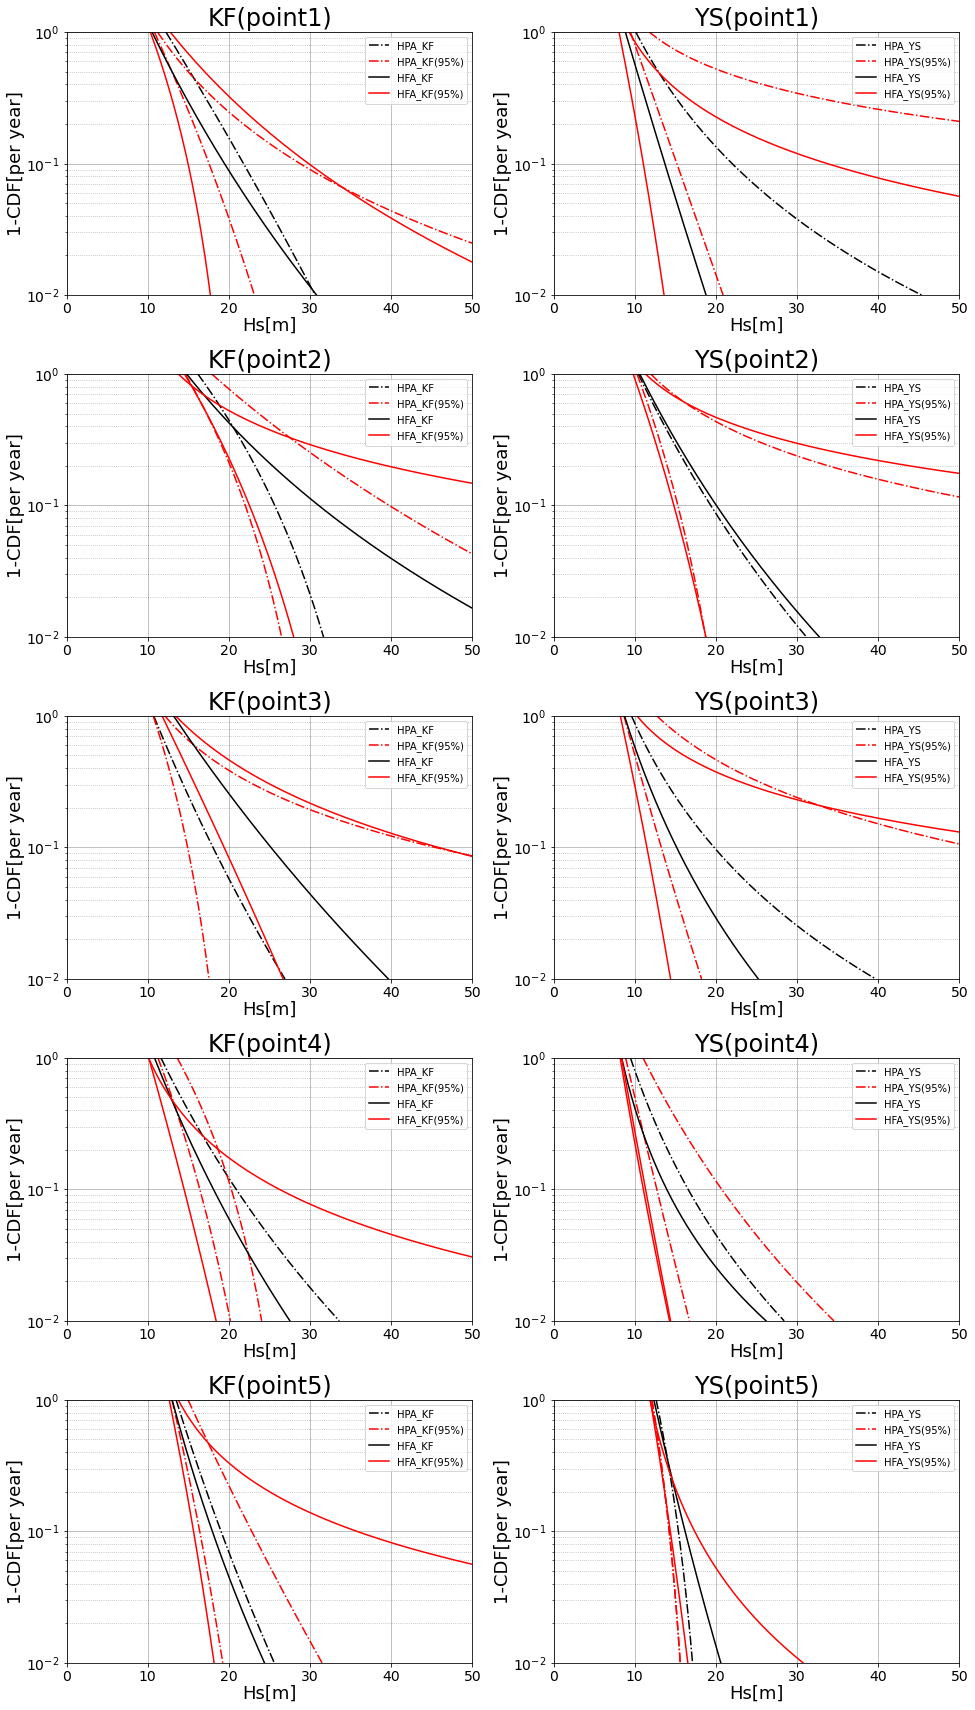

In [19]:
"""
LWMの出力結果を用いて, 極値増大確率の算出とCDFの描画をする.
"""

import func
from csv import reader
import matplotlib.pyplot as plt
import numpy as np

MODEL = ['KF', 'YS']
INDEX = [79*67 + 13, 79*43 + 23, 79*51 + 39, 79*42 + 60, 79*20 + 70]

def calc_p(past_rv, past_pro, f_rv, f_pro):
    """
    確率密度関数から, 極値増大確率を算出する
    """
    P = 0
    for i in range(len(past_rv)):
        p = 0
        for j in range(len(f_rv)):
            if f_rv[j] > past_rv[i]:
                p += f_pro[j]
        P += past_pro[i] * p
    return P * 100

def cdf(rv, pro):
    Hs = []
    SUM = []
    sum = 1
    s = [(rv[i], pro[i]) for i in range(len(rv))]
    s.sort()
    for i in range(len(rv)):
        sum -= s[i][1]
        SUM.append(sum)
        Hs.append(s[i][0])
    return Hs, SUM

def rv(N, u, xi, sgm):
    """
    N年再現期待値の算出 
    """
    return u + sgm * ((N * 24 * 365 * 100 / 219143) ** xi - 1) / xi


DATA_CNT = 50

# 描画用の画像を用意
fig = plt.figure(figsize=(16, 6 * len(INDEX)))
for index in range(len(INDEX)):
    print("----------", 'point' + str(index+1), "----------")
    idx = INDEX[index]
    for i in range(2):
        is_ok = True  # データ数がDATA_CNT以上あるかどうかのFlag(なければその地点は使用しない)
        for j in range(2):
            model = MODEL[i]
            # CSV名を指定するためにmodel名を変更
            if j == 0:  # 過去
                model = 'HPA_' + model
            else:  # 未来
                model = 'HFA_' + model + '_c0'
            with open('../pot_csv(100)(thr=6)/' + model + '_POT_DATA.csv', 'r') as csv_file:
                csv_reader = reader(csv_file)
                POT_ALL = list(csv_reader)
            POT = POT_ALL[idx] # 指定した場所のPOTを抽出
            # POTは文字列のリストになっているので, float型に変換する
            s = []
            for k in range(len(POT)):
                s.append(float(POT[k]))
            s = sorted(s, reverse=True)
            if len(POT) < 10:
                is_ok = False
                print("データ数：", len(POT), "データ数が不足しているため, この地点は使用できません")
            else:
                POT = s[:DATA_CNT]
                u = POT[-1]
                if j == 0:  # 過去
                    past_rv, past_pro, p_xi, p_sgm = func.lwm_gpd(data=POT, error=[0.005], thr=u, n=219143, n0=DATA_CNT, con=0.95)
                else:  # 将来
                    f_rv, f_pro, f_xi, f_sgm = func.lwm_gpd(data=POT, error=[0.005], thr=u, n=219143, n0=DATA_CNT, con=0.95)
        
        if is_ok:
            P = calc_p(past_rv, past_pro, f_rv, f_pro)
            # cdf_p_hs, cdf_p_sum = cdf(past_rv, past_pro)
            # cdf_f_hs, cdf_f_sum = cdf(f_rv, f_pro)
            print('{:.1f}'.format(P), '%の確率で極値増加')
            ax = fig.add_subplot(len(INDEX), 2, 2 * index + i+1)
            # MLのplot
            x = np.linspace(1, 100, 1000)
            ax.plot([rv(N=x_, u=u, xi=p_xi[1], sgm=p_sgm[1]) for x_ in x], [1/x_ for x_ in x], color='black', linestyle="dashdot", label='HPA_' + model[4:6])
            ax.plot([rv(N=x_, u=u, xi=p_xi[0], sgm=p_sgm[0]) for x_ in x], [1/x_ for x_ in x], color='red', linestyle="dashdot", label='HPA_' + model[4:6] + '(95%)')
            ax.plot([rv(N=x_, u=u, xi=p_xi[2], sgm=p_sgm[2]) for x_ in x], [1/x_ for x_ in x], color='red', linestyle="dashdot")
            ax.plot([rv(N=x_, u=u, xi=f_xi[1], sgm=f_sgm[1]) for x_ in x], [1/x_ for x_ in x], color='black', label=model[:-3])
            ax.plot([rv(N=x_, u=u, xi=f_xi[0], sgm=f_sgm[0]) for x_ in x], [1/x_ for x_ in x], color='red', label=model[:-3] + '(95%)')
            ax.plot([rv(N=x_, u=u, xi=f_xi[2], sgm=f_sgm[2]) for x_ in x], [1/x_ for x_ in x], color='red')
            # ax.plot(cdf_p_hs, cdf_p_sum, c='#aaaaFF')
            # ax.plot(cdf_f_hs, cdf_f_sum, c='#FFaaaa')
            # ax.legend(['HPA_' + model[4:6],'HPA_' + model[4:6] + '(95%)', model[:-3], model[:-3] + '(95%)'], fontsize=18)
            ax.legend()
            ax.set_xlim((0, 50))
            ax.set_ylim((0.01, 1))
            ax.set_xlabel("Hs[m]", fontsize=18, labelpad=1)
            ax.set_ylabel("1-CDF[per year]", fontsize=18, labelpad=1)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.set_title(MODEL[i] + '(point' + str(index+1) + ')', fontsize=24)
            ax.set_yscale('log')
            ax.grid(which='major',color='black',linestyle='-', alpha=0.3)
            ax.grid(which='minor',color='black',linestyle='dotted', alpha=0.3)

plt.subplots_adjust(hspace=0.3)
# plt.savefig("../img/cdf.png")
plt.show()